In [44]:
!pip3 install --upgrade pip

In [45]:
!pip3 install pandas

In [46]:
!pip3 install tqdm

In [47]:
!pip3 install torch torchvision

label
0    130908
1     89117
Name: count, dtype: int64


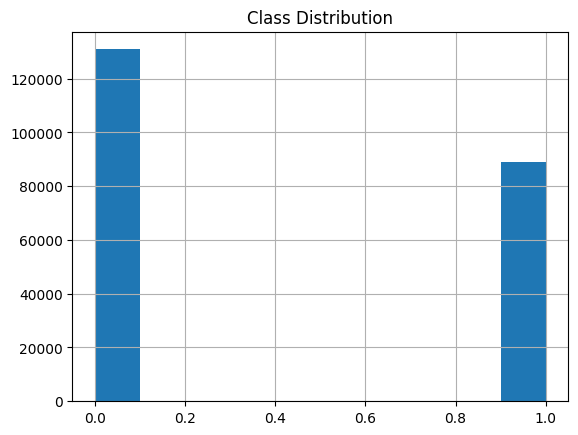

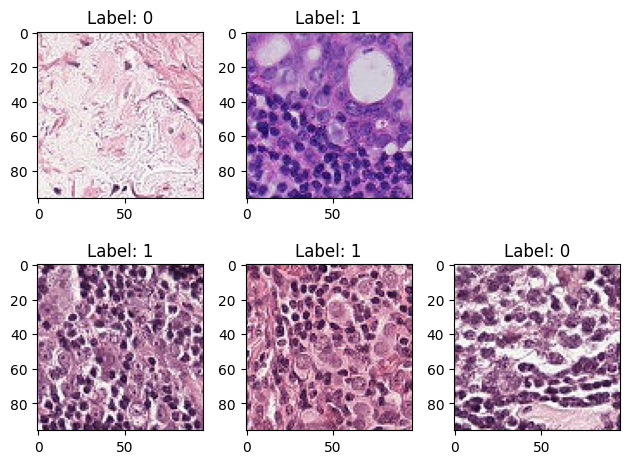

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

labels_df = pd.read_csv('/Users/maciflanagan/Downloads/histopathologic-cancer-detection/train_labels.csv')

print(labels_df['label'].value_counts())
labels_df['label'].hist()
plt.title("Class Distribution")
plt.show()

sample = labels_df.sample(6)
for i, row in sample.iterrows():
    
    img = Image.open(f"/Users/maciflanagan/Downloads/histopathologic-cancer-detection/train/{row['id']}.tif")
    plt.subplot(2, 3, i % 6 + 1)
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
plt.tight_layout()
plt.show()


In [75]:
print(labels_df.head())
print(labels_df.info())
print(labels_df.isnull().sum())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
id       0
label    0
dtype: int64


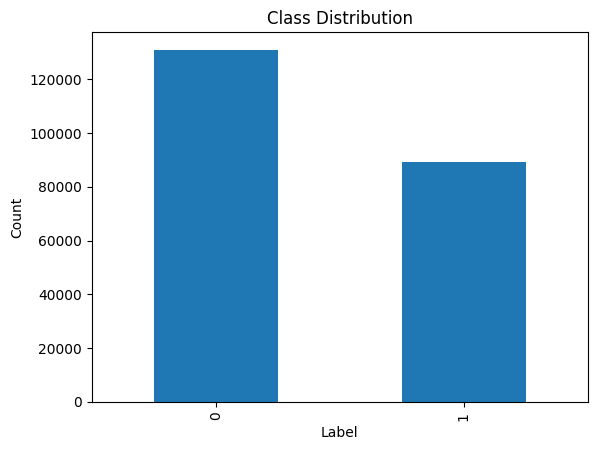

In [76]:
import matplotlib.pyplot as plt

labels_df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


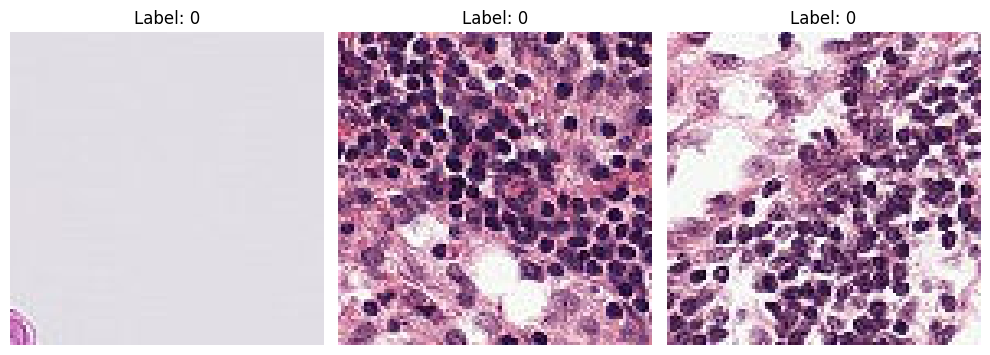

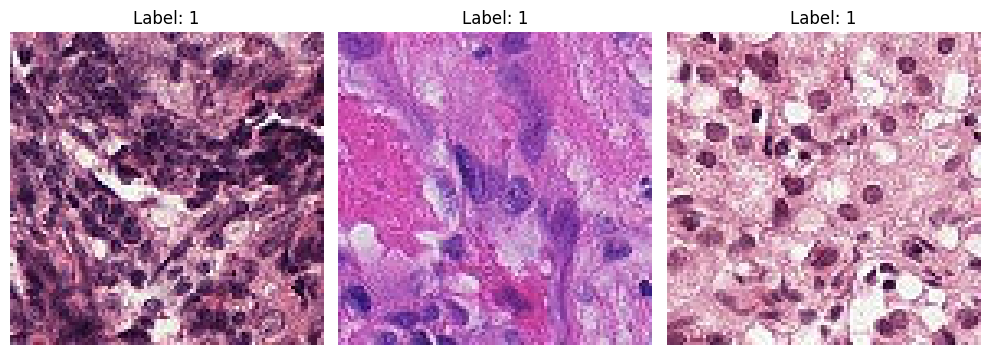

In [77]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(df, label, num=3):
    subset = df[df['label'] == label].sample(num)
    plt.figure(figsize=(10, 4))
    for i, row in enumerate(subset.itertuples()):
        img = Image.open(os.path.join(image_folder, f"{row.id}.tif"))
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

image_folder = '/Users/maciflanagan/Downloads/histopathologic-cancer-detection/train'

show_samples(labels_df, label=0)
show_samples(labels_df, label=1)


In [78]:
import numpy as np

def load_and_preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).resize(size)
    img_array = np.array(img) / 255.0
    return img_array


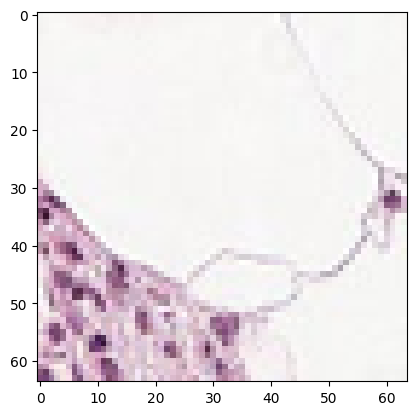

In [79]:
sample_id = labels_df.iloc[0]['id']
sample_path = f'/Users/maciflanagan/Downloads/histopathologic-cancer-detection/train/{sample_id}.tif'
processed_img = load_and_preprocess_image(sample_path)

plt.imshow(processed_img)
plt.show()


In [80]:
from tqdm import tqdm

sample_df = labels_df.head(1000)

X = []
y = []

for row in tqdm(sample_df.itertuples(), total=len(sample_df)):
    img_path = f'/Users/maciflanagan/Downloads/histopathologic-cancer-detection/train/{row.id}.tif'
    img = load_and_preprocess_image(img_path)
    X.append(img)
    y.append(row.label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 985.89it/s]

X shape: (1000, 64, 64, 3)
y shape: (1000,)


In [81]:
import torch.nn as nn
import torch.nn.functional as F

class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [82]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

model = CancerClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [83]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

class CancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id'] + '.tif')
        image = Image.open(img_path).resize((64, 64))
        image = np.array(image).transpose((2, 0, 1)) / 255.0
        label = np.float32(row['label'])
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [84]:
from torch.utils.data import DataLoader

img_dir = '/Users/maciflanagan/Downloads/histopathologic-cancer-detection/train/'

sample_df = labels_df.head(500)

dataset = CancerDataset(sample_df, img_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [85]:
epochs = 5
model.train()

for epoch in range(epochs):
    total_loss = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")


Epoch 1, Loss: 0.6789343114942312
Epoch 2, Loss: 0.6617709398269653
Epoch 3, Loss: 0.6524291317909956
Epoch 4, Loss: 0.6352303307503462
Epoch 5, Loss: 0.6239210739731789


In [86]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch

test_img_dir = '/Users/maciflanagan/Downloads/histopathologic-cancer-detection/test/'

test_ids = [f.split('.')[0] for f in os.listdir(test_img_dir) if f.endswith('.tif')]

predictions = []

model.eval()

with torch.no_grad():
    for img_id in test_ids:
        img_path = os.path.join(test_img_dir, img_id + '.tif')
        img = Image.open(img_path).resize((64, 64))
        img_array = np.array(img).transpose((2, 0, 1)) / 255.0
        img_tensor = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0)

        output = model(img_tensor).item()
        label = 1 if output >= 0.5 else 0
        predictions.append({'id': img_id, 'label': label})


In [87]:
submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submission.csv', index=False)